Learning to rank with scikit-learn: the pairwise transform
============================================================

This tutorial introduces the concept of pairwise preference used in most [ranking problems](http://en.wikipedia.org/wiki/Learning_to_rank). I'll use scikit-learn and for learning and matplotlib for visualization.

In the ranking setting, training data consists of lists of items with some order specified between items in each list. This order is typically induced by giving a numerical or ordinal score or a binary judgment (e.g. "relevant" or "not relevant") for each item, so that for any two samples `a` and `b`, either `a < b`, `b > a` or `b` and `a` are not comparable.

For example, in the case of a search engine, our dataset consists of results that belong to different queries and it makes sense to compare the relevance of results for the same query but it is meaningless to compare the relevance across queries, e.g. a result might be very relevant for a particular query but will probably be irrelevant for most other queries.

The order relationship is usually domain-specific. For instance, in information retrieval the set of comparable samples is refered to as a "query id". The goal behind this is to compare only documents that belong to the same query ([Joachims 2002](http://dx.doi.org/10.1145/775047.775067)). In medical imaging on the other hand, the order of the labels usually depend on the subject so the comparable samples is given by the different subjects in the study ([Pedregosa et al 2012](http://hal.inria.fr/hal-00717990/en)).

In [1]:
import itertools
import numpy as np
from scipy import stats
import pylab as pl
from sklearn import svm, linear_model, cross_validation

In [4]:
%matplotlib inline

In [52]:
# pl.scatter(X_train[~idx,0], X_train[~idx,1])
sum(b_train)

18

To start with, we'll create a dataset in which the target values consists of three graded measurements Y = {0, 1, 2} and the input data is a collection of 30 samples, each one with two features.

The set of comparable elements (queries in information retrieval) will consist of two equally sized blocks, $X = X_1 \cup X_2$, where each block is generated using a normal distribution with different mean and covariance. In the pictures, we represent $X_1$ with round markers and $X_2$ with triangular markers.

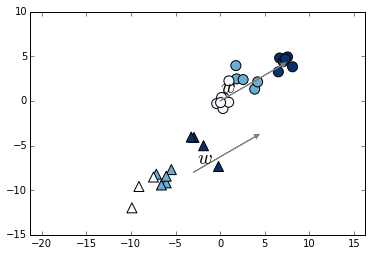

In [71]:
np.random.seed(0)
theta = np.deg2rad(60)
w = np.array([np.sin(theta), np.cos(theta)])
K = 20
X = np.random.randn(K, 2)
y = [0] * K
for i in range(1, 3):
    X = np.concatenate((X, np.random.randn(K, 2) + i * 4 * w))
    y = np.concatenate((y, [i] * K))

# slightly displace data corresponding to our second partition
X[::2] -= np.array([9, 10]) 
blocks = np.array([0, 1] * (X.shape[0] / 2))

# split into train and test set
cv = cross_validation.StratifiedShuffleSplit(y, test_size=.5)
train, test = iter(cv).next()
X_train, y_train, b_train = X[train], y[train], blocks[train]
X_test, y_test, b_test = X[test], y[test], blocks[test]

# plot the result
idx = (b_train == 0)
pl.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx], 
    marker='^', cmap=pl.cm.Blues, s=100)
pl.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx],
    marker='o', cmap=pl.cm.Blues, s=100)
pl.arrow(0, 0, 8 * w[0], 8 * w[1], fc='gray', ec='gray', 
    head_width=0.5, head_length=0.5)
pl.text(0, 1, '$w$', fontsize=20)
pl.arrow(-3, -8, 8 * w[0], 8 * w[1], fc='gray', ec='gray', 
    head_width=0.5, head_length=0.5)
pl.text(-2.6, -7, '$w$', fontsize=20)
pl.axis('equal')
pl.show()

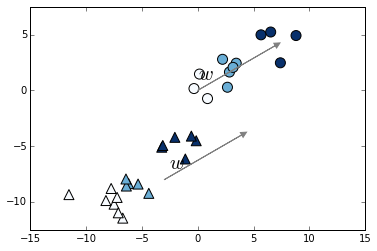

In [72]:
# plot the result
idx = (b_test == 0)
pl.scatter(X_test[idx, 0], X_test[idx, 1], c=y_test[idx], 
    marker='^', cmap=pl.cm.Blues, s=100)
pl.scatter(X_test[~idx, 0], X_test[~idx, 1], c=y_test[~idx],
    marker='o', cmap=pl.cm.Blues, s=100)
pl.arrow(0, 0, 8 * w[0], 8 * w[1], fc='gray', ec='gray', 
    head_width=0.5, head_length=0.5)
pl.text(0, 1, '$w$', fontsize=20)
pl.arrow(-3, -8, 8 * w[0], 8 * w[1], fc='gray', ec='gray', 
    head_width=0.5, head_length=0.5)
pl.text(-2.6, -7, '$w$', fontsize=20)
pl.axis('equal')
pl.show()

In the plot we clearly see that for both blocks there's a common vector w such that the projection onto w gives a list with the correct ordering.

However, because linear considers that output labels live in a metric space it will consider that all pairs are comparable. Thus if we fit this model to the problem above it will fit both blocks at the same time, yielding a result that is clearly not optimal. In the following plot we estimate $\hat{w}$ using an l2-regularized linear model.

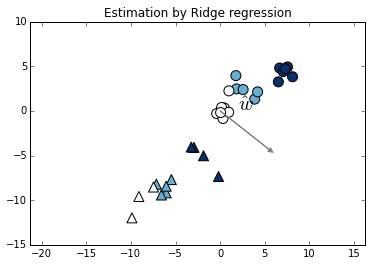

In [86]:
idx = (b_train == 0)
ridge = linear_model.Ridge(1.)
ridge.fit(X_train, y_train)
coef = ridge.coef_ / np.linalg.norm(ridge.coef_)
pl.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx], 
    marker='^', cmap=pl.cm.Blues, s=100)
pl.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx],
    marker='o', cmap=pl.cm.Blues, s=100)
pl.arrow(0, 0, 7 * coef[0], 7 * coef[1], fc='gray', ec='gray', 
    head_width=0.5, head_length=0.5)
pl.text(2, 0, '$\hat{w}$', fontsize=20)
pl.axis('equal')
pl.title('Estimation by Ridge regression')
pl.show()

To assess the quality of our model we need to define a ranking score. Since we are interesting in a model that *orders* the data, it is natural to look for a metric that compares the ordering of our model to the given ordering. For this, we use [Kendall's tau correlation coefficient](http://en.wikipedia.org/wiki/Kendall_tau_rank_correlation_coefficient), which is defined as (P - Q)/(P + Q), being P the number of concordant pairs and Q is the number of discordant pairs. This measure is used extensively in the ranking litterature (e.g [Optimizing Search Engines using Clickthrough Data](http://www.cs.cornell.edu/people/tj/publications/joachims_02c.pdf)).

We thus evaluate this metric on the test set for each block separately.

In [74]:
for i in range(2):
    tau, _ = stats.kendalltau(
        ridge.predict(X_test[b_test == i]), y_test[b_test == i])
    print('Kendall correlation coefficient for block %s: %.5f' % (i, tau))

Kendall correlation coefficient for block 0: 0.44549
Kendall correlation coefficient for block 1: 0.73614


The pairwise transform
----------------------

As proved in ([Herbrich 1999](http://www.mendeley.com/research/support-vector-learning-ordinal-regression/)), if we consider linear ranking functions, the ranking problem can be transformed into a two-class classification problem. For this, we form the difference of all comparable elements such that our data is transformed into $(x'_k, y'_k) = (x_i - x_j, sign(y_i - y_j))$ for all comparable pairs.

This way we transformed our ranking problem into a two-class classification problem. The following plot shows this transformed dataset, and color reflects the difference in labels, and our task is to separate positive samples from negative ones. The hyperplane {x^T w = 0} separates these two classes.

In [75]:
w

array([ 0.8660254,  0.5      ])

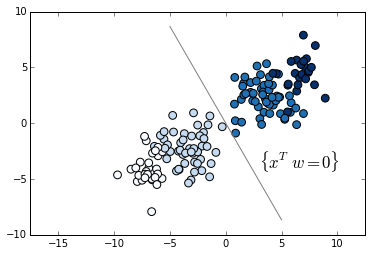

In [93]:
# form all pairwise combinations
comb = itertools.combinations(range(X_train.shape[0]), 2)
k = 0
Xp, yp, diff = [], [], []
for (i, j) in comb:
    if y_train[i] == y_train[j] or blocks[train][i] != blocks[train][j]:
        # skip if same target or different group
        continue
    Xp.append(X_train[i] - X_train[j])
    diff.append(y_train[i] - y_train[j])
    yp.append(np.sign(diff[-1]))
    # output balanced classes
    if yp[-1] != (-1) ** k:
        yp[-1] *= -1
        Xp[-1] *= -1
        diff[-1] *= -1
    k += 1
Xp, yp, diff = map(np.asanyarray, (Xp, yp, diff))
pl.scatter(Xp[:, 0], Xp[:, 1], c=diff, s=60, marker='o', cmap=pl.cm.Blues)
x_space = np.linspace(-10, 10)
pl.plot(x_space * w[1], - x_space * w[0], color='gray')
pl.text(3, -4, '$\{x^T w = 0\}$', fontsize=17)
pl.axis('equal')
pl.show()

As we see in the previous plot, this classification is separable. This will not always be the clase, however, in our training set  there are no order inversions, thus the respective classification problem is separable.

We will now finally train an Support Vector Machine model on the transformed data. This model is known as RankSVM. We will then plot the training data together with the estimated coefficient $\hat{w}$ by RankSVM.

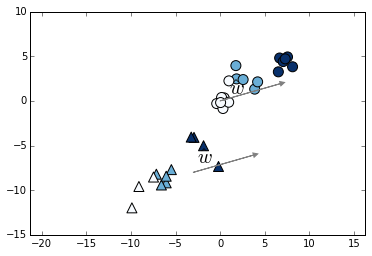

In [94]:
clf = svm.SVC(kernel='linear', C=.1)
clf.fit(Xp, yp)
coef = clf.coef_.ravel() / np.linalg.norm(clf.coef_)
pl.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx],
    marker='^', cmap=pl.cm.Blues, s=100)
pl.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx],
    marker='o', cmap=pl.cm.Blues, s=100)
pl.arrow(0, 0, 7 * coef[0], 7 * coef[1], fc='gray', ec='gray',
    head_width=0.5, head_length=0.5)
pl.arrow(-3, -8, 7 * coef[0], 7 * coef[1], fc='gray', ec='gray',
    head_width=0.5, head_length=0.5)
pl.text(1, .7, '$\hat{w}$', fontsize=20)
pl.text(-2.6, -7, '$\hat{w}$', fontsize=20)
pl.axis('equal')
pl.show()

Finally we will check that as expected, the ranking score (Kendall tau) increases with the RankSVM model respect to linear regression.

In [96]:
for i in range(2):
    tau, _ = stats.kendalltau(
        np.dot(X_test[b_test == i], coef), y_test[b_test == i])
    print('Kendall correlation coefficient for block %s: %.5f' % (i, tau))

Kendall correlation coefficient for block 0: 0.83627
Kendall correlation coefficient for block 1: 0.84387


This is indeed higher than the values (0.71122, 0.84387) obtained in the case of linear regression.